<h1>Sieci neuronowe - ćwiczenie 5</h1>

In [1]:
!pip install torch torchvision

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn.metrics as metrics

import torch
import torchvision
import torchvision.transforms as transforms
from torchmetrics.classification import MulticlassAccuracy, MulticlassPrecision, MulticlassF1Score, MulticlassRecall

In [3]:
torch.cuda.is_available() # check if torch is available to use GPU

False

In [4]:
# Def subset from whole dataset
def get_subset(data: torchvision.datasets.mnist.FashionMNIST, percent: int) -> torchvision.datasets.mnist.FashionMNIST:
    choices = np.random.choice(len(data), size=(int(len(data) * (percent / 100)),), replace=False) 
    return torch.utils.data.Subset(data, choices)

In [5]:
train_set = torchvision.datasets.FashionMNIST('path', download = True, train = True, transform = transforms.Compose([transforms.ToTensor()]))
test_set = torchvision.datasets.FashionMNIST('path', download = True, train = False, transform = transforms.Compose([transforms.ToTensor()]))

train_set = get_subset(train_set, 6)
test_set = get_subset(test_set, 6)


In [6]:
data_loader_train = torch.utils.data.DataLoader(train_set, batch_size=16, shuffle=True)
data_loader_test = torch.utils.data.DataLoader(test_set, batch_size=16, shuffle=True)

In [7]:
def lable_name(label: torch.Tensor):
    result = ""
    match label:
        case 0:
            result = "T-shirt/top"
        case 1:
            result = "Trouser"
        case 2:
            result = "Pullover"
        case 3:
            result = "Dress"
        case 4:
            result = "Coat"
        case 5:
            result = "Sandal"
        case 6:
            result = "Shirt"
        case 7:
            result = "Sneaker"
        case 8:
            result = "Bag"
        case 9:
            result = "Ankle boot"
    return result
            

T-shirt/top, Dress, Sandal, Ankle boot, T-shirt/top, Sneaker, Bag, Coat, Ankle boot, Coat, Trouser, Sandal, Shirt, Shirt, Shirt, Pullover, 

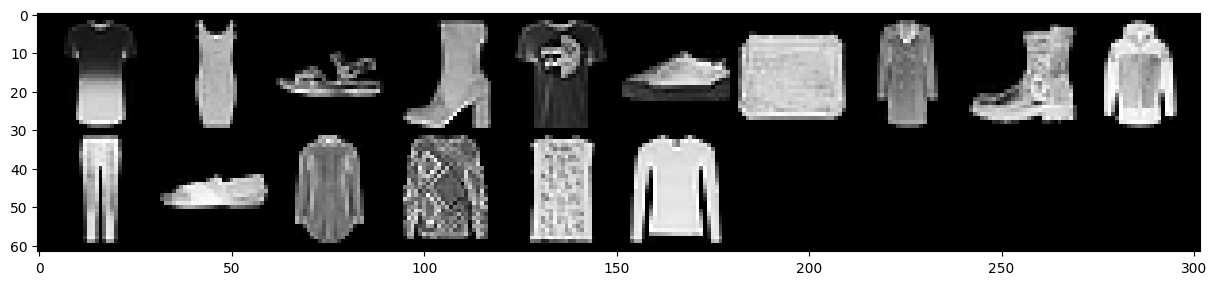

In [8]:
sample_images, sample_labels = next(iter(data_loader_train))
grid = torchvision.utils.make_grid(sample_images, nrow=10)

plt.figure(figsize=(15, 20))
plt.imshow(np.transpose(grid, (1, 2, 0)))

for _, label in enumerate(sample_labels):
    print(lable_name(label), end = ", ")

In [9]:
class MultilayerNetwork(torch.nn.Module):
    def __init__(self, hidden_layers_sizes: tuple, input_size: int, output_size: int):
        super(MultilayerNetwork, self).__init__()

        self._layers = torch.nn.ModuleList()
        curr_size = input_size
        for hidden_layer_size in hidden_layers_sizes:
            layer = torch.nn.Linear(curr_size, hidden_layer_size)
            torch.nn.init.normal_(layer.weight)
            torch.nn.init.normal_(layer.bias)
            self._layers.append(layer)
            self._layers.append(torch.nn.LeakyReLU())
            curr_size = hidden_layer_size
        output_layer = torch.nn.Linear(curr_size, output_size) 
        torch.nn.init.normal_(output_layer.weight)
        torch.nn.init.normal_(output_layer.bias)
        self._layers.append(output_layer)
        self._layers.append(torch.nn.LogSoftmax(dim=1))

    def forward(self, inputs):
        x = inputs
        for layer in self._layers:
            x = x.view(x.shape[0], -1)
            x = layer(x)
        return x

In [10]:
def train_model(model: torch.nn.Module, train_set: torch.Tensor, test_set: torch.Tensor, batch_size: int, optimizer, loss, max_iter: int, learning_rate: float, output_size: int, verb=False):
    
    optimizer = optimizer(model.parameters(), lr = learning_rate) 

    losses = []
    losses_test = []

    accuracy = []
    precision = []
    f_score = []
    recalls = []

    if batch_size > len(train_set):
        batch_size = len(train_set)

    data_loader_train = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True)
    data_loader_test = torch.utils.data.DataLoader(test_set, batch_size=batch_size, shuffle=True)

    metric_accuracy = MulticlassAccuracy(num_classes=output_size)
    metric_precision = MulticlassPrecision(num_classes=output_size)
    metric_f_score = MulticlassF1Score(num_classes=output_size)
    metric_recall = MulticlassRecall(num_classes=output_size)

    for index in range(max_iter): #learn for max_iter  
        curr_train_loss = 0   
        curr_test_loss = 0
        metric_accuracy.reset()
        metric_precision.reset()
        metric_f_score.reset()
        metric_recall.reset()
        
        # for each batch perform learning
        for x_train_batch, y_train_batch in data_loader_train:
            optimizer.zero_grad()
            y_pred = model(x_train_batch)
            loss_value = loss(y_pred, y_train_batch)
            loss_value.backward()
            optimizer.step()
            curr_train_loss += loss_value.item()
                
        losses.append(curr_train_loss / len(data_loader_train))

        with torch.no_grad():
            model.eval()
            for x_test_batch, y_test_batch in data_loader_test:
                test_pred = model(x_test_batch)
                loss_test_value = loss(test_pred, y_test_batch)
                curr_test_loss += loss_test_value.item()

                #calculate scores for each batch of iteration
                metric_accuracy.update(test_pred, y_test_batch)
                metric_precision.update(test_pred, y_test_batch)
                metric_f_score.update(test_pred, y_test_batch)
                metric_recall.update(test_pred, y_test_batch)

            losses_test.append(curr_test_loss / len(data_loader_test))    
            accuracy.append(metric_accuracy.compute())
            precision.append(metric_precision.compute())
            f_score.append(metric_f_score.compute())
            recalls.append(metric_recall.compute())

        if verb and index % 10 == 0:
            print("---------------------------------------------- Interation " + str(index))
            print("Train loss on " + str(index) + " iteration: ", losses[index])
            print("Test loss on " + str(index) + " iteration: ", losses_test[index])
            print("Accuracy on " + str(index) + " iteration: ", accuracy[index])
            print("Precision on " + str(index) + " iteration: ", precision[index])
            print("Recall on " + str(index) + " iteration: ", recalls[index])
            print("Fscore on " + str(index) + " iteration: ", f_score[index])
            print("----------------------------------------------\n")

    print("Result of learning process for " + str(max_iter) + " iterations")
    print("--------------------------------------------------------\n")
    print("Train loss: ", losses[-1])
    print("Test loss: ", losses_test[-1])
    print("----------------------------------------------\n")
    print("Scores")
    print("Accuracy: ", accuracy[-1])
    print("Precision: ", precision[-1])
    print("F_score: ", f_score[-1])
    print("Recall: ", recalls[-1])    
    return losses, losses_test, accuracy, f_score, recalls

In [11]:
def plot_learning(losses: list, losses_test: list, title: str, axs = None):
    if axs == None:
        plt.plot(np.arange(len(losses)), losses, label="Train Loss")
        plt.plot(np.arange(len(losses)), losses_test, label="Test loss")
        plt.title(title)
        plt.legend()
        plt.show()
    else:
        axs.plot(np.arange(len(losses)), losses, label="Train Loss")
        axs.plot(np.arange(len(losses)), losses_test, label="Test loss")
        axs.set_title(title)
        axs.legend()

<h1>Eksperymenty</h1>

<h4>Jednowarstwowa sieć</h4>

In [15]:
optimizer = torch.optim.Adam
loss = torch.nn.CrossEntropyLoss()
max_iter = 100
verbose = False

#1 Liczba neuronów w warstwie ukrytej
hiddenLayer_1 = (20,)
hiddenLayer_2 = (50,)

#2 Rozmiar batch'a
batch_size_1 = 16
batch_size_2 = 100
batch_size_3 = 1000

#3 Liczba przykładów uczących
train_set_1 = get_subset(train_set, 1)
test_set_1 = get_subset(test_set, 1)
train_set_10 = get_subset(train_set, 10)
test_set_10 = get_subset(test_set, 10)

#4 Zaburzenie danych



In [22]:
model = MultilayerNetwork(hiddenLayer_1, train_set[0][0].shape[1] * train_set[0][0].shape[2], 10)
result = train_model(model, train_set, test_set, 16, optimizer, loss, max_iter, 0.0008, 10, verb=True)

# plt.style.use('seaborn-muted')


---------------------------------------------- Interation 0
Train loss on 0 iteration:  14.063213443756103
Test loss on 0 iteration:  5.3020979856189925
Accuracy on 0 iteration:  tensor(0.1417)
Precision on 0 iteration:  tensor(0.1850)
Recall on 0 iteration:  tensor(0.1417)
Fscore on 0 iteration:  tensor(0.1240)
----------------------------------------------

---------------------------------------------- Interation 10
Train loss on 10 iteration:  1.1937475906478034
Test loss on 10 iteration:  1.2548678940848301
Accuracy on 10 iteration:  tensor(0.5887)
Precision on 10 iteration:  tensor(0.6060)
Recall on 10 iteration:  tensor(0.5887)
Fscore on 10 iteration:  tensor(0.5880)
----------------------------------------------

---------------------------------------------- Interation 20
Train loss on 20 iteration:  0.8126390181647407
Test loss on 20 iteration:  0.9643376061790868
Accuracy on 20 iteration:  tensor(0.6705)
Precision on 20 iteration:  tensor(0.6804)
Recall on 20 iteration:  ten

<p><i>Wykonane przez Szymona Sawczuka nr indeksu 260287</i></p>

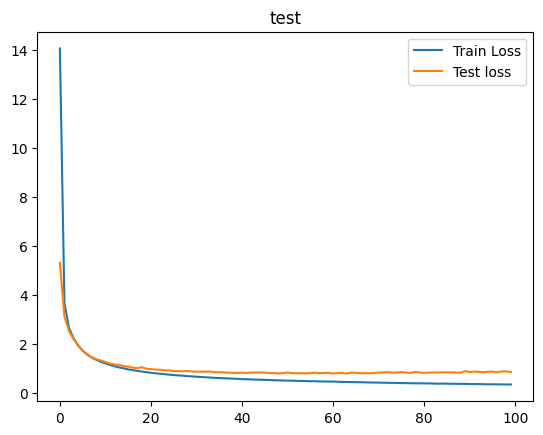

In [23]:
plot_learning(result[0], result[1], "test")